In [46]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import datetime as dt

In [47]:
#pip install cython

In [48]:
#pip install pystan

In [49]:
#-m pip install prophet

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

In [51]:
import sklearn
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

In [52]:
def performance(actual, predicted):
    print('MAE', round(mae(actual, predicted), 3))
    print('RMSE', round(mse(actual, predicted)**0.5, 3))
    print('MAPE', round(mape(actual, predicted), 3))

In [53]:
mobile_sales = pd.read_excel('mobilesales.xlsx')

In [54]:
mobile_sales.set_index('DATE',inplace=True)
mobile_sales

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0
...,...
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0


In [55]:
mobile_sales.index.dtype

dtype('<M8[ns]')

In [56]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method= 'linear')
mobile_sales.Sales

DATE
2001-01-01     6519.0
2001-02-01     6654.0
2001-03-01     7332.0
2001-04-01     7332.0
2001-05-01     8240.0
               ...   
2018-09-01    13838.0
2018-10-01    15351.0
2018-11-01    15615.0
2018-12-01    16941.0
2019-01-01    12160.0
Name: Sales, Length: 217, dtype: float64

## Clipping

In [57]:
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.95), lower=mobile_sales.Sales.quantile(0.05))

## Autocorrelation

In [58]:
original = mobile_sales.Sales[1:]
shift_1 = mobile_sales.Sales.shift(1).dropna()
np.corrcoef(original, shift_1)

array([[1.        , 0.81071664],
       [0.81071664, 1.        ]])

In [59]:
## Keep going. At 12, corr is the highest!
original = mobile_sales.Sales[12:]
shift_1 = mobile_sales.Sales.shift(12).dropna()
np.corrcoef(original, shift_1)

array([[1.        , 0.94190985],
       [0.94190985, 1.        ]])

In [60]:
mobile_sales.Sales.shift(12).dropna()[0]

C:\Users\ryanr\AppData\Local\Temp\ipykernel_13004\1939624265.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mobile_sales.Sales.shift(12).dropna()[0]


np.float64(7307.8)

## ACF & PACF ONLY FOR STATIONARY TS


<StemContainer object of 3 artists>

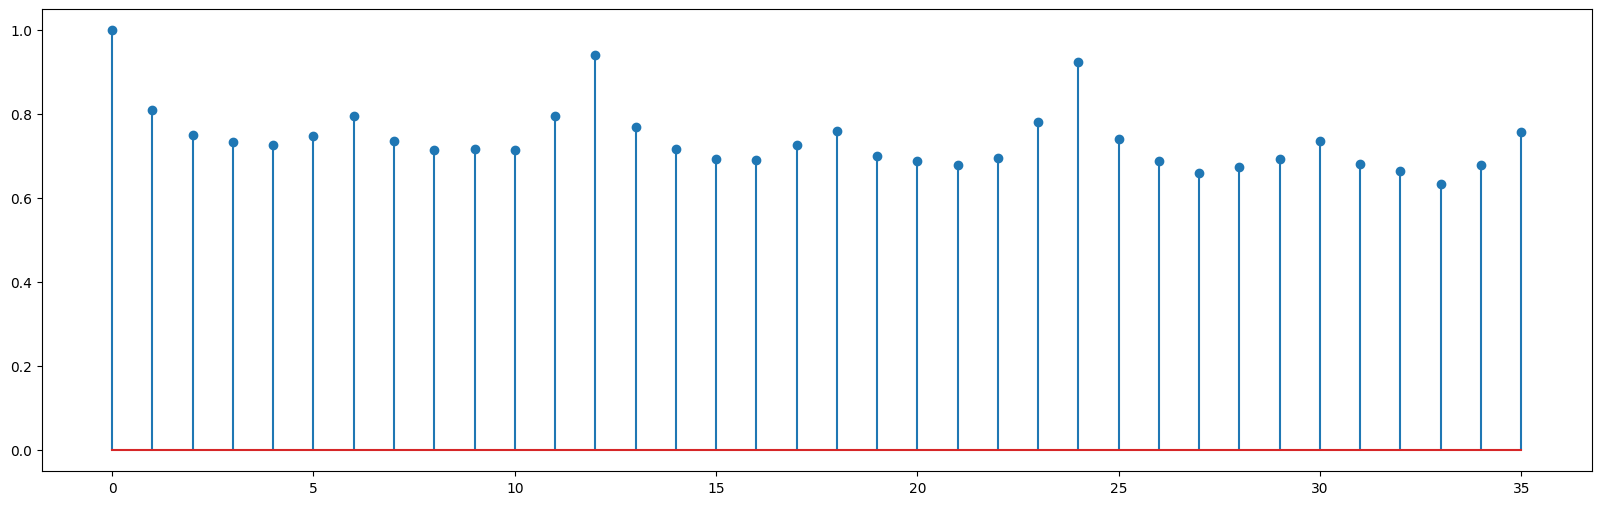

In [61]:
#Declare an empty corr array to store the shifted array
corr = []
for lag in range(36):
    corr.append(np.corrcoef(mobile_sales.Sales[lag:], mobile_sales.Sales.shift(lag).dropna())[0][1])

plt.stem(np.arange(36), corr)

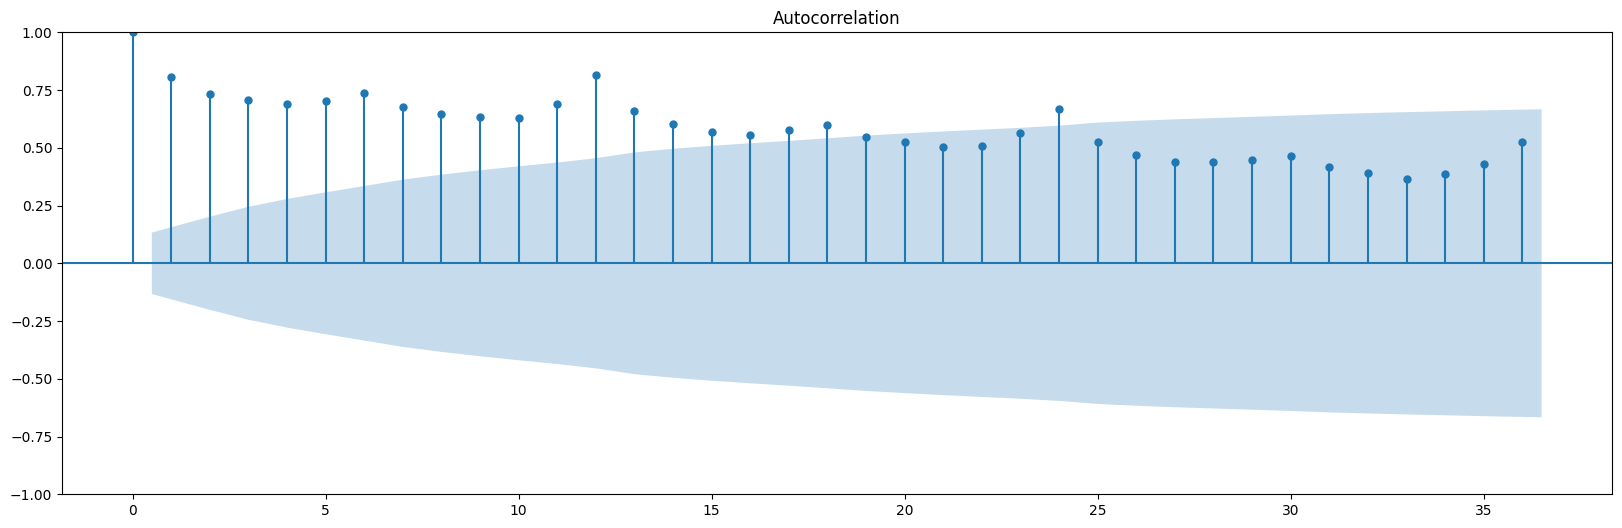

In [62]:
#Method 2 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(mobile_sales.Sales, lags=36);

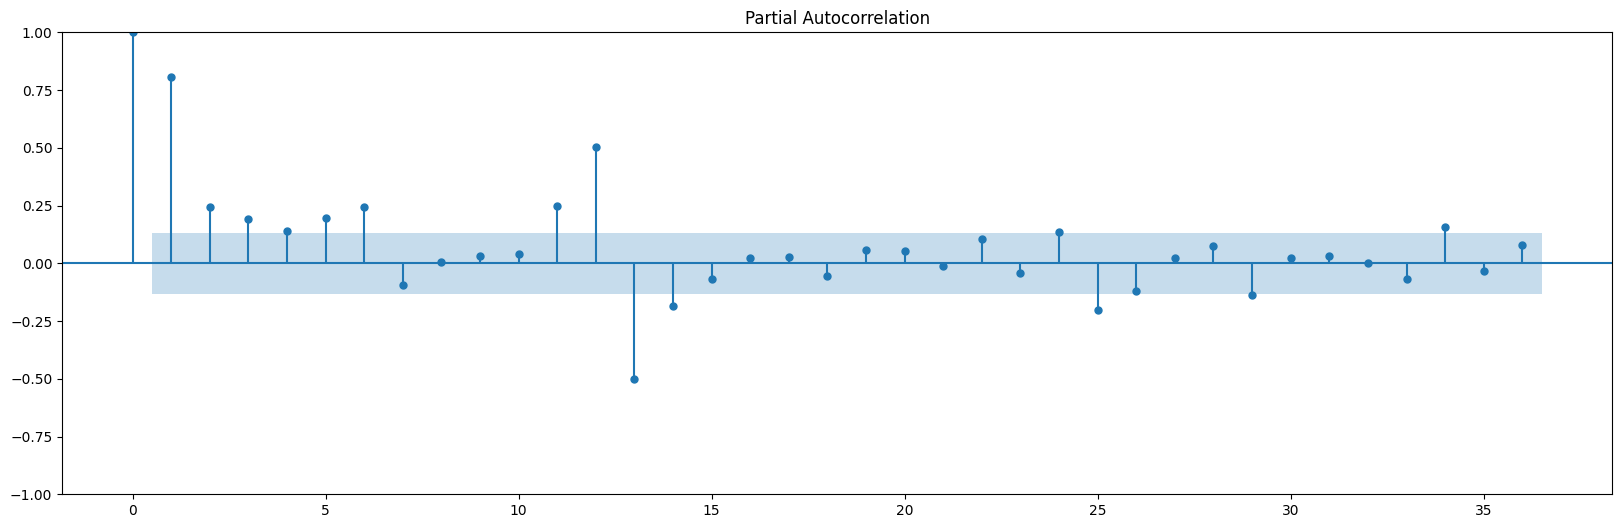

In [63]:
plot_pacf(mobile_sales.Sales, lags=36);

In [64]:
# trend and seasonality
# decomposition

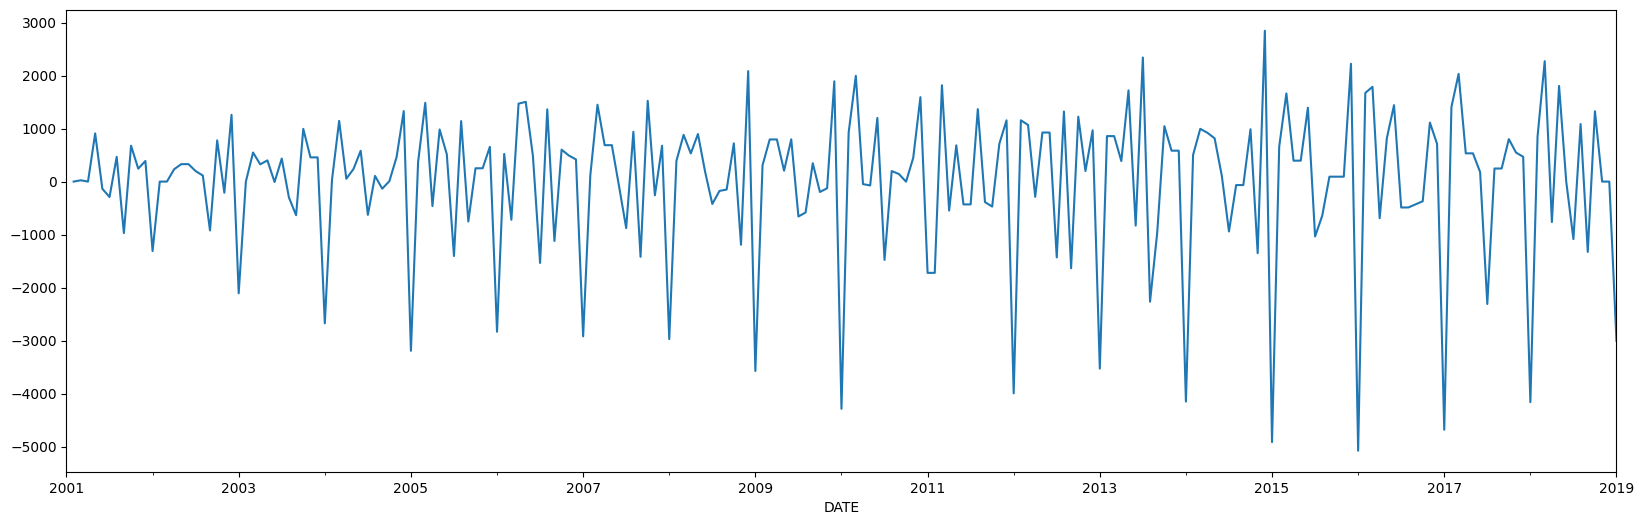

In [65]:
mobile_sales.Sales.diff(1).plot();

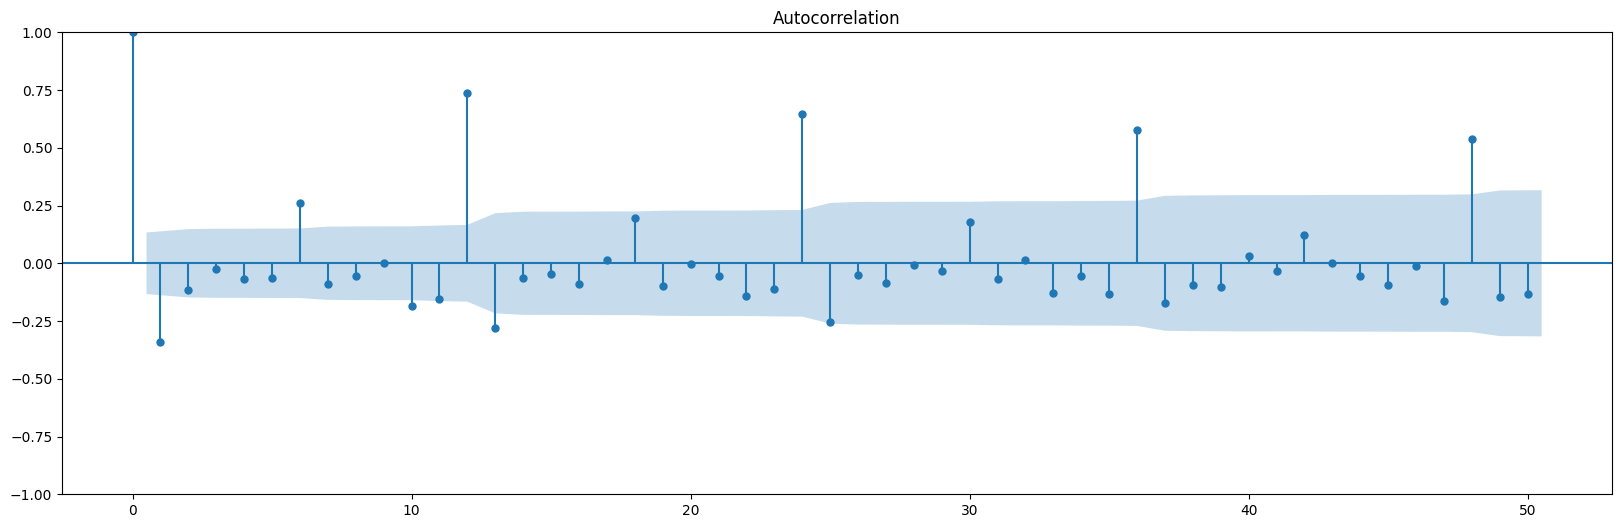

In [66]:
plot_acf(mobile_sales.Sales.diff().dropna(), lags = 50);

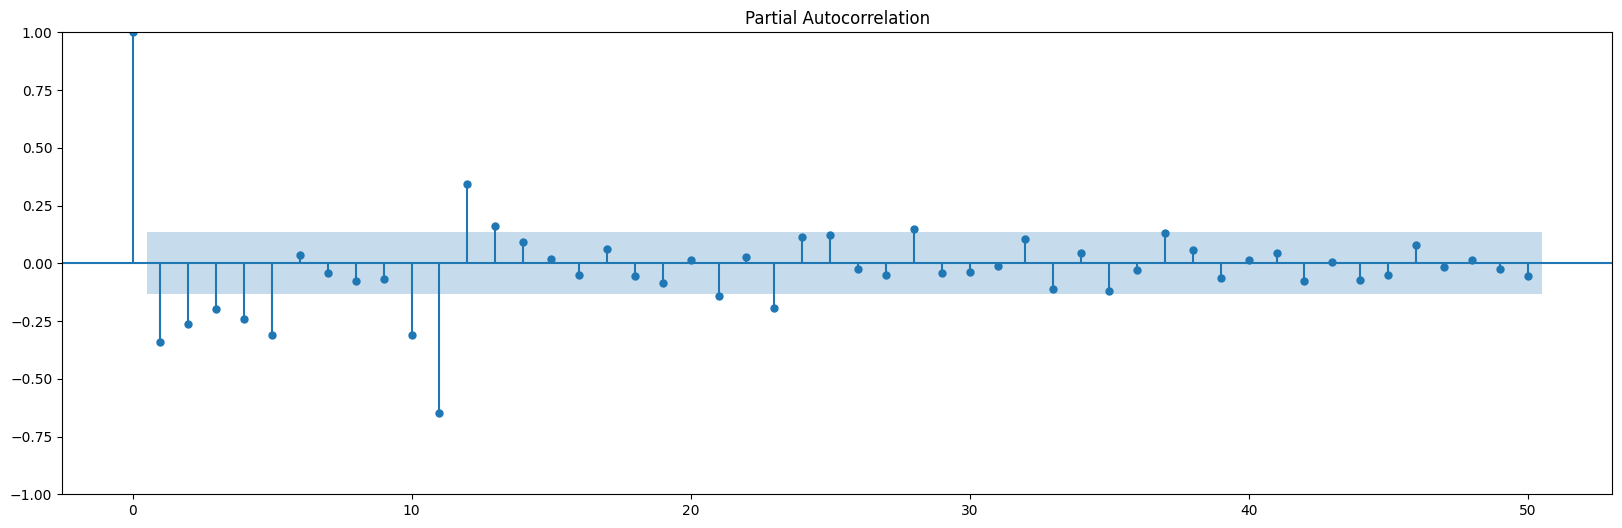

In [67]:
plot_pacf(mobile_sales.Sales.diff().dropna(), lags = 50);

## Change Point
Using ruptures library in Python

## Prophet

In [68]:
df = pd.read_csv('rest_vis.csv')
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [69]:
df1 = df.copy()

In [70]:
df.dropna(inplace=True)

In [71]:
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [72]:
df = df1.copy()
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total']
df = df[['ds', 'y', 'holiday']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       517 non-null    datetime64[ns]
 1   y        478 non-null    float64       
 2   holiday  517 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 12.2 KB


In [73]:
df.head()

,ds,y,holiday
0,2016-01-01,296.0,1
1,2016-01-02,191.0,0
2,2016-01-03,202.0,0
3,2016-01-04,105.0,0
4,2016-01-05,98.0,0


In [74]:
from prophet import Prophet

m = Prophet()
m.fit(df[['ds', 'y']][:-39]) #on training data

future = m.make_future_dataframe(periods=39, freq="D")
forecast = m.predict(future)
forecast.head()

23:19:34 - cmdstanpy - INFO - Chain [1] start processing
23:19:34 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,143.018440,117.699834,199.873782,143.018440,143.018440,15.209684,15.209684,15.209684,15.209684,15.209684,15.209684,0.0,0.0,0.0,158.228124
1,2016-01-02,142.946140,198.504180,277.486755,142.946140,142.946140,94.500797,94.500797,94.500797,94.500797,94.500797,94.500797,0.0,0.0,0.0,237.446937
2,2016-01-03,142.873839,151.048501,231.060999,142.873839,142.873839,46.766092,46.766092,46.766092,46.766092,46.766092,46.766092,0.0,0.0,0.0,189.639931
3,2016-01-04,142.801539,59.341593,142.555167,142.801539,142.801539,-42.868527,-42.868527,-42.868527,-42.868527,-42.868527,-42.868527,0.0,0.0,0.0,99.933012
4,2016-01-05,142.729238,62.339959,142.731644,142.729238,142.729238,-39.704575,-39.704575,-39.704575,-39.704575,-39.704575,-39.704575,0.0,0.0,0.0,103.024663


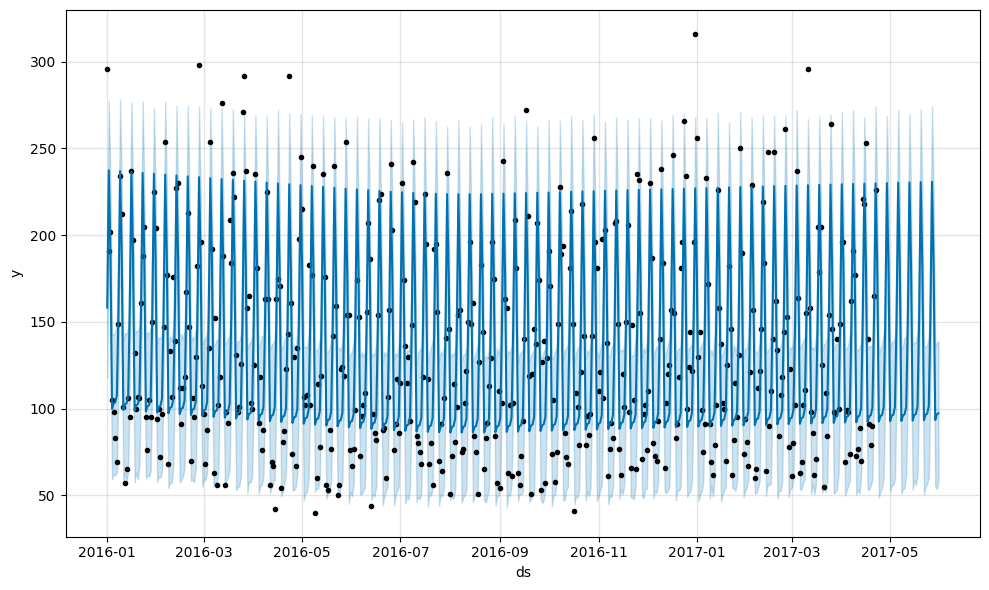

In [75]:
m.plot(forecast);